# Modeling the Hourly Rate

This code trains a model to predict what a prospective freelancers hourly rate should be. The model used is a random forest regression model. I also built an AdaBoosted Decision Tree model, but it performs much worse (using 5-fold cross-validation) compared with the turned random forest regression model.

I've also built a k-modes (cluster with categorical/numeric mixed data) model. It is currently being tested.

# Prep

## Importing Libraries and Data

In [1]:
# Data Analysis and Modeling
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import time

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# AdaBoost Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# LASSO
from sklearn.linear_model import LassoCV, Lasso

# XGBoost
import xgboost as xgb

# Cross-Validation and Accuracy Measures
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

# Model Serializing (export to web-app)
import pickle

# Packages for PostgreSQL Import
import psycopg2
import os

# Packages for K-Modes Cluster
from kmodes.kmodes import KModes

## Importing Data from SQL

In [2]:
# Names for accessing SQL database
dbname = "freelance_db"
username = os.environ['USER']
pswd = os.environ['SQLPSWD']

# Connect to SQL Database
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# Importing Data
sql_query = """SELECT * FROM analysis_dummies_table;"""
analysis_dt = pd.read_sql_query(sql_query, con)

sql_query = """SELECT * FROM embeddings_table;"""
embeddings = pd.read_sql_query(sql_query, con)

# Doing some cleaning. Removing columns that have a continuous analog in the model.
analysis_dt = analysis_dt.drop(['index'], axis=1)
analysis_dt = analysis_dt.drop(['first_skill'], axis = 1)

# Removing index col from embeddings
embeddings = embeddings.drop(['index'], axis = 1)
embeddings['profile_url'] = "https://www.guru.com" + embeddings['profile_url']

# Merging on profile_url
analysis_dt = analysis_dt.merge(embeddings, how = "left", 
                                left_on = "profile_url", right_on= "profile_url")
analysis_dt = analysis_dt.drop(['profile_url'], axis = 1)
analysis_dt = analysis_dt.fillna(0)

# Cleaning avg_word_length and bio_word count
analysis_dt.loc[analysis_dt['bio_length'] == 0, ['bio_word_count','avg_word_length']] = 0

# Removing Crazy Outliers
analysis_dt.drop(analysis_dt[analysis_dt['hourly_rate'] > 100].index, inplace = True)
analysis_dt.shape

(964, 114)

## Prepping Data for Training

In [3]:
# Converting data to numpy arrays and saving column names
y = np.array(analysis_dt['hourly_rate'])

analysis_dt = analysis_dt.drop(['hourly_rate'], axis = 1)
feature_list = list(analysis_dt.columns)

X = np.array(analysis_dt)

In [4]:
# Creating train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Modeling - XGBoost

In [6]:
# Convert Data into DMatrix
dtest = xgb.DMatrix(X_test, label=y_test)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.save_binary((os.environ['PWD'] + '/data/cleaned/train.buffer'))
dtest.save_binary((os.environ['PWD'] + '/data/cleaned/test.buffer'))

In [7]:
# Baseline Model without Tuning
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric': "mae"
}

num_boost_round = 999

# Cross-Validated XGBoost
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

# MAE With Default Params = 15.50499

[0]	Test-mae:20.17713
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:17.22973
[2]	Test-mae:16.08314
[3]	Test-mae:15.58959
[4]	Test-mae:15.50499
[5]	Test-mae:15.74091
[6]	Test-mae:16.07302
[7]	Test-mae:16.19855
[8]	Test-mae:16.46500
[9]	Test-mae:16.45968
[10]	Test-mae:16.55776
[11]	Test-mae:16.59185
[12]	Test-mae:16.74085
[13]	Test-mae:16.83016
[14]	Test-mae:16.87075
Stopping. Best iteration:
[4]	Test-mae:15.50499



In [8]:
# Reference: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(2, 20, 2)
    for min_child_weight in range(2, 20, 2)
]

min_mae = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
        max_depth,
        min_child_weight))    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best MAE
    
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth, min_child_weight)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=2, min_child_weight=2
	MAE 15.4107316 for 5 rounds
CV with max_depth=2, min_child_weight=4
	MAE 15.416767400000001 for 5 rounds
CV with max_depth=2, min_child_weight=6
	MAE 15.416767400000001 for 5 rounds
CV with max_depth=2, min_child_weight=8
	MAE 15.421375399999999 for 5 rounds
CV with max_depth=2, min_child_weight=10
	MAE 15.419965999999999 for 5 rounds
CV with max_depth=2, min_child_weight=12
	MAE 15.389829599999999 for 5 rounds
CV with max_depth=2, min_child_weight=14
	MAE 15.3914782 for 5 rounds
CV with max_depth=2, min_child_weight=16
	MAE 15.409867 for 4 rounds
CV with max_depth=2, min_child_weight=18
	MAE 15.423952400000001 for 6 rounds
CV with max_depth=4, min_child_weight=2
	MAE 15.6884388 for 4 rounds
CV with max_depth=4, min_child_weight=4
	MAE 15.628003999999999 for 4 rounds
CV with max_depth=4, min_child_weight=6
	MAE 15.5467798 for 4 rounds
CV with max_depth=4, min_child_weight=8
	MAE 15.538757999999998 for 4 rounds
CV with max_depth=4, min_child_weig

In [9]:
# Updating params dictionary with selected values
params['max_depth'] = 2
params['min_child_weight'] = 12

In [10]:
# Tuning subsample and colsample_bytree
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,11)]
    for colsample in [i/10. for i in range(1,11)]
]

min_mae = float("Inf")
best_params = None# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
        
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

CV with subsample=1.0, colsample=1.0
	MAE 15.3898292 for 5 rounds
CV with subsample=1.0, colsample=0.9
	MAE 15.3874636 for 5 rounds
CV with subsample=1.0, colsample=0.8
	MAE 15.4829522 for 4 rounds
CV with subsample=1.0, colsample=0.7
	MAE 15.450802 for 4 rounds
CV with subsample=1.0, colsample=0.6
	MAE 15.339092400000002 for 4 rounds
CV with subsample=1.0, colsample=0.5
	MAE 15.360109799999998 for 4 rounds
CV with subsample=1.0, colsample=0.4
	MAE 15.5965004 for 4 rounds
CV with subsample=1.0, colsample=0.3
	MAE 15.702760799999998 for 4 rounds
CV with subsample=1.0, colsample=0.2
	MAE 15.879101400000001 for 4 rounds
CV with subsample=1.0, colsample=0.1
	MAE 15.9938606 for 4 rounds
CV with subsample=0.9, colsample=1.0
	MAE 15.473707399999999 for 4 rounds
CV with subsample=0.9, colsample=0.9
	MAE 15.462648999999999 for 5 rounds
CV with subsample=0.9, colsample=0.8
	MAE 15.425058400000001 for 4 rounds
CV with subsample=0.9, colsample=0.7
	MAE 15.4145232 for 4 rounds
CV with subsample=0.9

In [11]:
# Tuning ETA (learning rate)
min_mae = float("Inf")
best_params = None

for eta in [.3, .2, .1, .07, .05, .02, .01, .005]:
    print("CV with eta={}".format(eta))    # We update our parameters
    params['eta'] = eta    # Run and time CV
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics=['mae'],
        early_stopping_rounds=10
    )    # Update best score
    
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta

print("Best params: {}, MAE: {}".format(best_params, min_mae))

params['eta'] = best_params

CV with eta=0.3
	MAE 15.2778454 for 4 rounds

CV with eta=0.2
	MAE 15.338374400000001 for 7 rounds

CV with eta=0.1
	MAE 15.401718599999999 for 16 rounds

CV with eta=0.07
	MAE 15.3685294 for 25 rounds

CV with eta=0.05
	MAE 15.342504 for 37 rounds

CV with eta=0.02
	MAE 15.2733768 for 94 rounds

CV with eta=0.01
	MAE 15.3112674 for 183 rounds

CV with eta=0.005
	MAE 15.3117074 for 371 rounds

Best params: 0.02, MAE: 15.2733768


In [12]:
# Train Final Model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-mae:26.85500
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:26.28794
[2]	Test-mae:25.71911
[3]	Test-mae:25.18005
[4]	Test-mae:24.63767
[5]	Test-mae:24.11353
[6]	Test-mae:23.58127
[7]	Test-mae:23.11086
[8]	Test-mae:22.69963
[9]	Test-mae:22.29082
[10]	Test-mae:21.91689
[11]	Test-mae:21.56964
[12]	Test-mae:21.22121
[13]	Test-mae:20.87109
[14]	Test-mae:20.56210
[15]	Test-mae:20.26608
[16]	Test-mae:19.96790
[17]	Test-mae:19.69532
[18]	Test-mae:19.44053
[19]	Test-mae:19.20138
[20]	Test-mae:18.96594
[21]	Test-mae:18.73932
[22]	Test-mae:18.52958
[23]	Test-mae:18.34005
[24]	Test-mae:18.17947
[25]	Test-mae:18.00093
[26]	Test-mae:17.84043
[27]	Test-mae:17.68801
[28]	Test-mae:17.53601
[29]	Test-mae:17.39289
[30]	Test-mae:17.24901
[31]	Test-mae:17.12037
[32]	Test-mae:17.00357
[33]	Test-mae:16.90865
[34]	Test-mae:16.82658
[35]	Test-mae:16.74205
[36]	Test-mae:16.67019
[37]	Test-mae:16.59058
[38]	Test-mae:16.51202
[39]	Test-mae:16.44210
[40]	Test-mae:16.38360
[41]	Test-m

In [13]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:26.85500
[1]	Test-mae:26.28794
[2]	Test-mae:25.71911
[3]	Test-mae:25.18005
[4]	Test-mae:24.63767
[5]	Test-mae:24.11353
[6]	Test-mae:23.58127
[7]	Test-mae:23.11086
[8]	Test-mae:22.69963
[9]	Test-mae:22.29083
[10]	Test-mae:21.91690
[11]	Test-mae:21.56963
[12]	Test-mae:21.22121
[13]	Test-mae:20.87108
[14]	Test-mae:20.56210
[15]	Test-mae:20.26608
[16]	Test-mae:19.96790
[17]	Test-mae:19.69532
[18]	Test-mae:19.44053
[19]	Test-mae:19.20138
[20]	Test-mae:18.96594
[21]	Test-mae:18.73932
[22]	Test-mae:18.52958
[23]	Test-mae:18.34005
[24]	Test-mae:18.17947
[25]	Test-mae:18.00093
[26]	Test-mae:17.84043
[27]	Test-mae:17.68801
[28]	Test-mae:17.53601
[29]	Test-mae:17.39289
[30]	Test-mae:17.24900
[31]	Test-mae:17.12037
[32]	Test-mae:17.00357
[33]	Test-mae:16.90865
[34]	Test-mae:16.82658
[35]	Test-mae:16.74205
[36]	Test-mae:16.67019
[37]	Test-mae:16.59058
[38]	Test-mae:16.51202
[39]	Test-mae:16.44210
[40]	Test-mae:16.38360
[41]	Test-mae:16.34487
[42]	Test-mae:16.29872
[43]	Test-mae:16.2557

In [18]:
# Exporting model
filename = os.environ['PWD'] + '/scripts/model_xgb.model'
filename_dump = os.environ['PWD'] + '/scripts/dump.raw.txt'

best_model.save_model(filename)
best_model.dump_model(filename_dump)

Baseline Performance: 
Mean Absolute Error: 17.69
Model Performance: 
Mean absolute error: 15.68
Mean squared error: 446.01
Coefficient of determination: 0.03
A  11.4 percent change over the mean


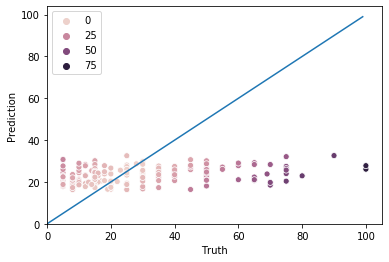

In [19]:
print("Baseline Performance: ")
baseline_performance(y_train, y_test)

print("Model Performance: ")
model_performance(bst.predict(dtest), y_test, 17.69)

# Plotting True Hourly Rates vs Predicted Hourly Rates
plot_preds_truth(x = y_test, y = bst.predict(dtest))

# Modeling - LASSO

In [37]:
# Running model
model_lasso = LassoCV(cv=20).fit(X_train, y_train)

# Saving model with pickle
filename = os.environ['PWD'] + '/scripts/model_lasso.sav'
pickle.dump(model_lasso, open(filename, 'wb'))

/Users/Metaverse/Desktop/Insight/projects/myrate/scripts/model_lasso.sav


In [48]:
# This is to avoid division by zero while doing np.log10
EPSILON = 1e-4
preds_lasso = model_lasso.predict(X_test)

print("Baseline Performance: ")
baseline_performance(y_train, y_test)

print("Model Performance: ")
model_performance(preds_lasso, y_test, 17.69)

Baseline Performance: 
Mean Absolute Error: 17.69
Model Performance: 
Mean absolute error: 16.94
Mean squared error: 442.01
Coefficient of determination: 0.04
A  4.3 percent change over the mean


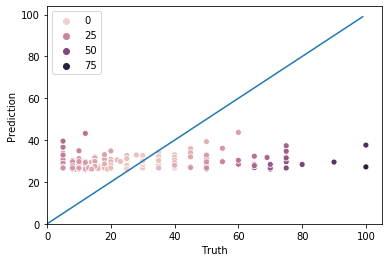

In [49]:
# Plotting True Hourly Rates vs Predicted Hourly Rates
plot_preds_truth(x = y_test, y = preds_lasso)

# Modeling - Random Forest Regression
## Estimating a Random Forest Regression to Estimate Hourly-Rate

Notes:
    - Next model probability of getting a job?
    - Convert to a clustering algorithm and present a range of estimates?
    - Bootstrap to get a range of estimates?
    - Make suggestions (Increase bio length by 10 and you can charge X more)
        - "Here are bios for users similar to you" etc. etc.
    - Focus on helping users build up their profiles

In [50]:
# References for GridSearchCV
# 1 - https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters
# 2 - https://stackoverflow.com/questions/35097003/cross-validation-decision-trees-in-sklearn
# References for Random Forest Regression
# 1 - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# 2 - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# Creating parameter grid
parameters = {"max_features": ["auto", "sqrt"], 
              "n_estimators": [100, 500, 900, 1300, 1500], 
              "max_depth": [None,5,10,20]}

# Creating Grid Search Class
clf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=4, verbose=True, 
                   scoring="neg_mean_absolute_error",
                   refit=True, cv = 3)

# Running Grid Search
clf.fit(X=X_train, y=y_train)

# Saving best model
model_rfr = clf.best_estimator_

# Printing results
print(round(clf.best_score_,2), clf.best_params_)

# Exporting model
filename = os.environ['PWD'] + '/scripts/model_rfr.sav'
pickle.dump(model_rfr, open(filename, 'wb'))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 19.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 20.1min finished


-15.72 {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}


## Evaluating Model

In [51]:
preds_rfr = model_rfr.predict(X_test)

print("Baseline Performance: ")
baseline_performance(y_train, y_test)

print("Model Performance: ")
model_performance(preds_rfr, y_test, 17.69)

Baseline Performance: 
Mean Absolute Error: 17.69
Model Performance: 
Mean absolute error: 16.78
Mean squared error: 432.31
Coefficient of determination: 0.06
A  5.1 percent change over the mean


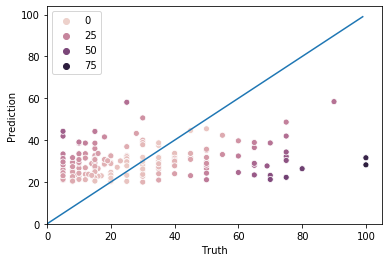

In [52]:
# Plotting True Hourly Rates vs Predicted Hourly Rates
plot_preds_truth(x = y_test, y = preds_rfr)

# Fitting AdaBoost Model
The reason to fit this model is that iteratively re-weights observations based on how poorly the model predicts them. This pushes the model to finding a way to predict observations other models may miss. I am concerned, however, if it will overfit to outliers.

It performs poorly compared to the random forest regression.

In [40]:
# Creating parameter grid
parameters = {"n_estimators": [1, 3, 5, 10, 25, 50, 75, 100, 125, 150],
              "base_estimator__max_depth": [3, 5, 7, 9, 10, 11]}

regr_1 = DecisionTreeRegressor()
regr_2 = AdaBoostRegressor(base_estimator=regr_1)

# Creating Grid Search Class
clf = GridSearchCV(regr_2, parameters, n_jobs=4, verbose=True)

# Running Grid Search
clf.fit(X=X_train, y=y_train)

# Saving best model
model_ada = clf.best_estimator_

# Printing results
print(round(clf.best_score_, 2), clf.best_params_)

# Exporting Model
filename = os.environ['PWD'] + '/scripts/model_ada.sav'
pickle.dump(model_ada, open(filename, 'wb'))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   47.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.5min finished


0.01 {'base_estimator__max_depth': 7, 'n_estimators': 75}


## Evaluating Model Performance

In [45]:
preds_ada = model_ada.predict(X_test)

print("Baseline Performance: ")
baseline_performance(y_train, y_test)

print("Model Performance: ")
model_performance(preds_ada, y_test, 17.69)

Baseline Performance: 
Mean Absolute Error: 17.69
Model Performance: 
Mean absolute error: 17.82
Mean squared error: 457.09
Coefficient of determination: 0.01
A  -0.7000000000000001 percent change over the mean


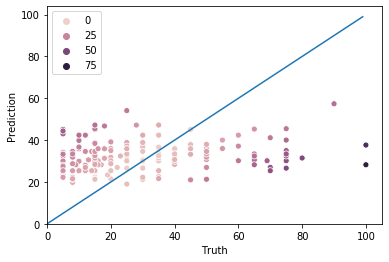

In [47]:
# Plotting True Hourly Rates vs Predicted Hourly Rates
plot_preds_truth(x = y_test, y = preds_ada)